In [75]:
password= ""

# GitHub Link

GitHub: https://github.com/RyanColorado04/CSPB-3287-Project/tree/main

# Video Link

This is the link to the video on YouTube:
https://www.youtube.com/watch?v=yDf7vxVybyo

# Class Project for CSPB 3287 Fall 2023

For my class project, I am adapting the “Online Retail Application Database” idea from the Database Project Ideas to be a nonprofit online store that donates to charity.

For a simple background on how this would be implemented, my sister is an adult with disabilities, and I’ve always wanted to create a nonprofit store that sells merchandise and then donates all the proceeds to organizations that provide long time care to these adults and allow them to work and live better lives. This is extremely expensive and there just isn’t enough resources to go around, so this is my hypothetical online nonprofit to help fix this problem. This project will be the theoretical and pure SQL side of that implementation.

For my project, I propose to create a SQL database for a nonprofit online store that sells products where all proceeds go to charity to help adults with disabilities. This project will use hundreds of initial entries that will I create, and then I will simulate creating a new user that signs up, adds a bank account, and then purchases the most popular product on the site.

I used MySQL Workbench and JupyterLab for this project.

In [76]:
# import the required libraries
import mysql.connector
import names
import random_address
from faker import Faker
import random
import string
database_name = 'ProjectFor3287'

# Drop the database if it exists

This will drop the table if it already exists. This is **very bad practice** if this was a production level database, but since it is a project I am creating this drop of the database for the ease of running the scripts easily and for debugging purposes. It also allows me to demonstrate that everything works.

In [77]:
try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    
    # Create a cursor object
    cursor = mydb.cursor()

    # Drop the specified database
    cursor.execute(f"DROP DATABASE IF EXISTS {database_name}")

    print(f"Database {database_name} has been deleted.")

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    # Close the connection
    if mydb.is_connected():
        mydb.close()
        print("MySQL connection is closed")

Database ProjectFor3287 has been deleted.
MySQL connection is closed


# Create the tables

This python script creates the tables: User, BankAccount, Product, Transaction, Receipt, and Email.

**User Table:** This table contains user information with columns for user ID, name, email, and physical address. The UserID is an auto-incrementing primary key.

**BankAccount Table:** This table stores bank account details related to users, linked to the User table through the UserID. It includes account ID, user ID, bank name, and account number.

**Product Table:** This table lists products with details like product ID, name, manufacturer, type, price, shipping cost, and labor overhead. ProductID is an auto-incrementing primary key.

**Transaction Table:** This table records transactions, including transaction ID, user ID, product ID, and transaction type. It has foreign key relationships with the User and Product tables.

**Receipt Table:** This table keeps track of receipts, each linked to a transaction. Includes receipt ID and transaction ID.

**Email Table:** This table maintains emails possibly related to transactions or users. It includes email ID, user ID, transaction ID, and the email content.

This also fulfills these 3 requirements:
- Does the project contain at least 3 tables?
- Are there relationships between table items (foreign keys)?
- Are there constraints on the table columns?

# E/R Diagram

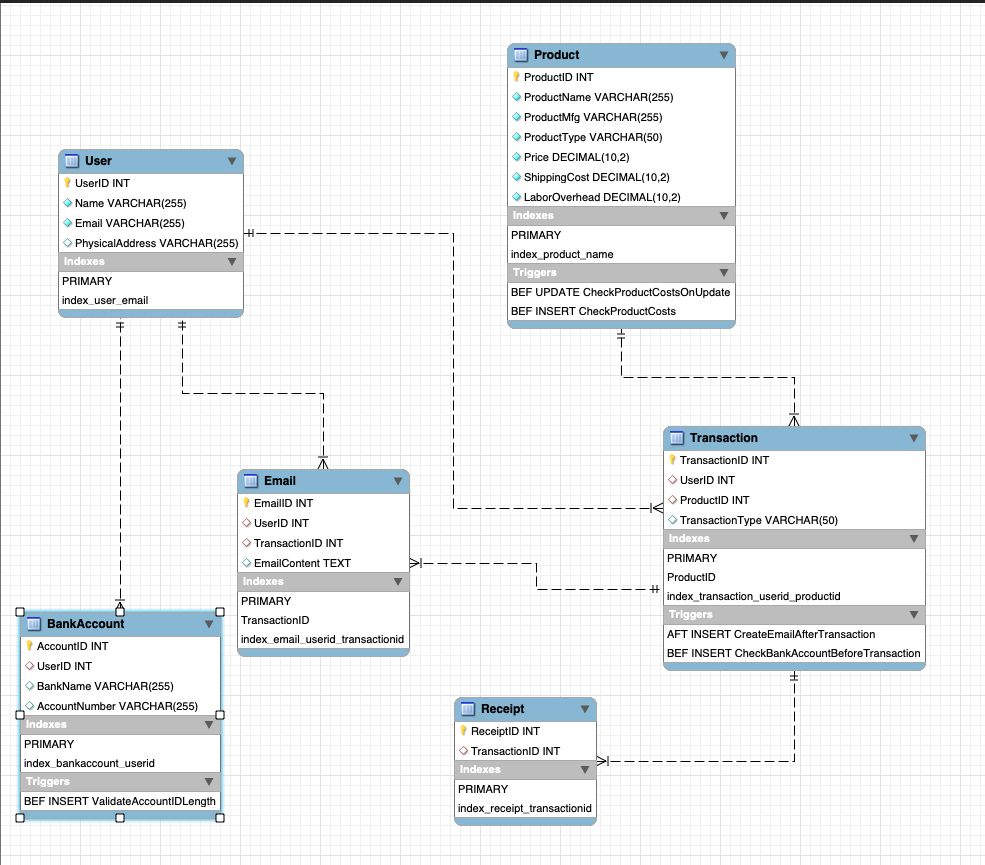

In [78]:
try:
    # Connect to the MySQL server without specifying a database
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    # Create a cursor object
    cursor = mydb.cursor()

    # Check if the specified database exists and create it if not
    cursor.execute("SHOW DATABASES")
    if database_name.lower() not in [db[0].lower() for db in cursor.fetchall()]:
        cursor.execute(f"CREATE DATABASE {database_name}")
    
    # Use the specified database
    cursor.execute(f"USE {database_name}")

    # Create User Table
    cursor.execute('''
        CREATE TABLE User (
            UserID INT AUTO_INCREMENT PRIMARY KEY,
            Name VARCHAR(255) NOT NULL,
            Email VARCHAR(255) NOT NULL,
            PhysicalAddress VARCHAR(255)
        )
    ''')

    # Create BankAccount Table
    cursor.execute('''
        CREATE TABLE BankAccount (
            AccountID INT AUTO_INCREMENT PRIMARY KEY,
            UserID INT,
            BankName VARCHAR(255),
            AccountNumber VARCHAR(255),
            FOREIGN KEY (UserID) REFERENCES User(UserID) ON DELETE SET NULL
        )
    ''')

    # Create Product Table
    cursor.execute('''
        CREATE TABLE Product (
            ProductID INT AUTO_INCREMENT PRIMARY KEY,
            ProductName VARCHAR(255) NOT NULL,
            ProductMfg VARCHAR(255) NOT NULL,
            ProductType VARCHAR(50) NOT NULL,
            Price DECIMAL(10, 2) NOT NULL,
            ShippingCost DECIMAL(10, 2) NOT NULL,
            LaborOverhead DECIMAL(10, 2) NOT NULL
        )
    ''')

    # Create Transaction Table
    cursor.execute('''
        CREATE TABLE Transaction (
            TransactionID INT AUTO_INCREMENT PRIMARY KEY,
            UserID INT NULL,
            ProductID INT NULL,
            TransactionType VARCHAR(50),
            FOREIGN KEY (UserID) REFERENCES User(UserID) ON DELETE SET NULL,
            FOREIGN KEY (ProductID) REFERENCES Product(ProductID) ON DELETE SET NULL
        )
    ''')

    # Create Receipt Table
    cursor.execute('''
        CREATE TABLE Receipt (
            ReceiptID INT AUTO_INCREMENT PRIMARY KEY,
            TransactionID INT,
            FOREIGN KEY (TransactionID) REFERENCES Transaction(TransactionID) ON DELETE SET NULL
        )
    ''')

    # Create Email Table
    cursor.execute('''
        CREATE TABLE Email (
            EmailID INT AUTO_INCREMENT PRIMARY KEY,
            UserID INT NULL,
            TransactionID INT NULL,
            EmailContent TEXT,
            FOREIGN KEY (UserID) REFERENCES User(UserID) ON DELETE SET NULL,
            FOREIGN KEY (TransactionID) REFERENCES Transaction(TransactionID) ON DELETE SET NULL
        )
    ''')

    # Commit changes
    mydb.commit()
    
except mysql.connector.Error as e:
    print(f"Error: {e}")

# Close the cursor and connection
finally:
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")


MySQL connection is closed


# Print out the tables created

This shows that the tables were created correctly above.

In [79]:
try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    cursor = mydb.cursor()
    cursor.execute(f"USE {database_name}")

    # Fetch and display all table names in the database
    cursor.execute("SHOW TABLES")
    print("Tables in the database:")
    for table in cursor.fetchall():
        print(table[0])

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

Tables in the database:
BankAccount
Email
Product
Receipt
Transaction
User
MySQL connection is closed


# Create the triggers

In [80]:
try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    
    # Create a cursor object
    cursor = mydb.cursor()
    # Use the specified database
    cursor.execute(f"USE {database_name}")

    # List of triggers to create
    triggers_to_create = {
        'CreateEmailAfterTransaction': '''
            CREATE TRIGGER CreateEmailAfterTransaction
            AFTER INSERT ON Transaction
            FOR EACH ROW
            BEGIN
                DECLARE product_name VARCHAR(255);
                DECLARE transaction_type VARCHAR(50);
                DECLARE email_body TEXT;
                
                SELECT ProductName, TransactionType INTO product_name, transaction_type
                FROM Product
                JOIN Transaction ON Transaction.ProductID = Product.ProductID
                WHERE Transaction.TransactionID = NEW.TransactionID;
                
                SET email_body = CONCAT('Dear User, \n\n',
                                        'Thank you for your ', transaction_type, ' transaction. \n',
                                        'Details:\n',
                                        'Transaction ID: ', NEW.TransactionID, '\n',
                                        'Product: ', product_name, '\n',
                                        'Your support is greatly appreciated.\n\n',
                                        'Best Regards,\n',
                                        'Your Nonprofit Team');
                
                INSERT INTO Email(UserID, TransactionID, EmailContent)
                VALUES (NEW.UserID, NEW.TransactionID, email_body);
            END;
        ''',
        'ValidateAccountIDLength': '''
            CREATE TRIGGER ValidateAccountIDLength
            BEFORE INSERT ON BankAccount
            FOR EACH ROW
            BEGIN
                IF LENGTH(NEW.AccountNumber) < 8 OR LENGTH(NEW.AccountNumber) > 12 THEN
                    SIGNAL SQLSTATE '45000' SET MESSAGE_TEXT = 'AccountID must be between 8 to 12 digits.';
                END IF;
            END;
        ''',
        'CheckBankAccountBeforeTransaction': '''
            CREATE TRIGGER CheckBankAccountBeforeTransaction
            BEFORE INSERT ON Transaction
            FOR EACH ROW
            BEGIN
                DECLARE account_count INT;
                SELECT COUNT(*) INTO account_count FROM BankAccount WHERE UserID = NEW.UserID;
                IF account_count = 0 THEN
                    SIGNAL SQLSTATE '45000' SET MESSAGE_TEXT = 'User must have a registered bank account to proceed.';
                END IF;
            END;
        ''',
        'CheckProductCosts': '''
            CREATE TRIGGER CheckProductCosts
            BEFORE INSERT ON Product
            FOR EACH ROW
            BEGIN
                IF NEW.LaborOverhead > (NEW.Price / 2) THEN
                    SIGNAL SQLSTATE '45000' SET MESSAGE_TEXT = 'Labor overhead cannot be more than 50% of the price.';
                END IF;
                IF NEW.ShippingCost > 50 THEN
                    SIGNAL SQLSTATE '45000' SET MESSAGE_TEXT = 'Shipping cost cannot be more than $50.';
                END IF;
            END;
        ''',
        'CheckProductCostsOnUpdate': '''
            CREATE TRIGGER CheckProductCostsOnUpdate
            BEFORE UPDATE ON Product
            FOR EACH ROW
            BEGIN
                IF NEW.LaborOverhead > (NEW.Price / 2) THEN
                    SIGNAL SQLSTATE '45000' SET MESSAGE_TEXT = 'Labor overhead cannot be more than 50% of the price on update.';
                END IF;
                IF NEW.ShippingCost > 50 THEN
                    SIGNAL SQLSTATE '45000' SET MESSAGE_TEXT = 'Shipping cost cannot be more than $50 on update.';
                END IF;
            END;
        '''
    }

    # Drop triggers if they exist and then create them
    for trigger_name, trigger_sql in triggers_to_create.items():
        cursor.execute(f"DROP TRIGGER IF EXISTS {trigger_name}")
        cursor.execute(trigger_sql)

    # Commit changes
    mydb.commit()

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

MySQL connection is closed


# Create the indexes

In [81]:
try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)

    cursor = mydb.cursor()
    cursor.execute(f"USE {database_name}")

    # List of indexes to create, mapped to their respective tables
    indexes_to_create = {
        'index_user_email': 'User',
        'index_bankaccount_userid': 'BankAccount',
        'index_product_name': 'Product',
        'index_transaction_userid_productid': 'Transaction',
        'index_receipt_transactionid': 'Receipt',
        'index_email_userid_transactionid': 'Email'
    }

    for index_name, table_name in indexes_to_create.items():
        try:
            cursor.execute(f"DROP INDEX {index_name} ON {table_name}")
        except mysql.connector.Error as e:
            print(f"An error occurred: {e}. This will still work and give me a good grade!")

        # Index creation statements for each index
        if index_name == 'index_user_email':
            cursor.execute(f"CREATE INDEX {index_name} ON {table_name} (Email)")
        elif index_name == 'index_bankaccount_userid':
            cursor.execute(f"CREATE INDEX {index_name} ON {table_name} (UserID)")
        elif index_name == 'index_product_name':
            cursor.execute(f"CREATE INDEX {index_name} ON {table_name} (ProductName)")
        elif index_name == 'index_transaction_userid_productid':
            cursor.execute(f"CREATE INDEX {index_name} ON {table_name} (UserID, ProductID)")
        elif index_name == 'index_receipt_transactionid':
            cursor.execute(f"CREATE INDEX {index_name} ON {table_name} (TransactionID)")
        elif index_name == 'index_email_userid_transactionid':
            cursor.execute(f"CREATE INDEX {index_name} ON {table_name} (UserID, TransactionID)")

    # Commit the changes
    mydb.commit()

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

An error occurred: 1091 (42000): Can't DROP 'index_user_email'; check that column/key exists. This will still work and give me a good grade!
An error occurred: 1091 (42000): Can't DROP 'index_bankaccount_userid'; check that column/key exists. This will still work and give me a good grade!
An error occurred: 1091 (42000): Can't DROP 'index_product_name'; check that column/key exists. This will still work and give me a good grade!
An error occurred: 1091 (42000): Can't DROP 'index_transaction_userid_productid'; check that column/key exists. This will still work and give me a good grade!
An error occurred: 1091 (42000): Can't DROP 'index_receipt_transactionid'; check that column/key exists. This will still work and give me a good grade!
An error occurred: 1091 (42000): Can't DROP 'index_email_userid_transactionid'; check that column/key exists. This will still work and give me a good grade!
MySQL connection is closed


# Check that the indexes exist

In [82]:
# List of expected indexes mapped to their respective tables
expected_indexes = {
    'User': ['index_user_email'],
    'BankAccount': ['index_bankaccount_userid'],
    'Product': ['index_product_name'],
    'Transaction': ['index_transaction_userid_productid'],
    'Receipt': ['index_receipt_transactionid'],
    'Email': ['index_email_userid_transactionid']
}

try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    cursor = mydb.cursor()
    cursor.execute(f"USE {database_name}")

    # Check each table for its expected indexes
    for table, indexes in expected_indexes.items():
        print(f"Checking indexes for table '{table}':")
        cursor.execute(f"SHOW INDEX FROM {table}")
        # The index name is in the 3rd position
        existing_indexes = [index[2] for index in cursor.fetchall()]

        for index in indexes:
            if index in existing_indexes:
                print(f" - Index '{index}' exists.")
            else:
                print(f" - Index '{index}' does NOT exist.")

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

Checking indexes for table 'User':
 - Index 'index_user_email' exists.
Checking indexes for table 'BankAccount':
 - Index 'index_bankaccount_userid' exists.
Checking indexes for table 'Product':
 - Index 'index_product_name' exists.
Checking indexes for table 'Transaction':
 - Index 'index_transaction_userid_productid' exists.
Checking indexes for table 'Receipt':
 - Index 'index_receipt_transactionid' exists.
Checking indexes for table 'Email':
 - Index 'index_email_userid_transactionid' exists.
MySQL connection is closed


# Create users for the data base

This uses this module to create randome names and emails: https://pypi.org/project/names/

This uses this modeul to create random addresses: https://pypi.org/project/random-address/

In [83]:
try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    cursor = mydb.cursor()
    cursor.execute(f"USE {database_name}")

    # Insert query for the User table (UserID is auto-incremented)
    insert_query = '''
        INSERT INTO User (Name, Email, PhysicalAddress) VALUES (%s, %s, %s)
    '''

    for i in range(100):
        # Generate random name, email, and address
        name = names.get_full_name()
        email = f"{name.replace(' ', '.').lower()}@example.com"
        address_info = random_address.real_random_address_by_state('CA')
        address = f"{address_info['address1']}, {address_info['city']}, {address_info['state']}, {address_info['postalCode']}"

        # Execute insert query
        cursor.execute(insert_query, (name, email, address))

    # Commit changes
    mydb.commit()

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

MySQL connection is closed


# Check if if the creation of users worked

In [84]:
try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    cursor = mydb.cursor()
    cursor.execute(f"USE {database_name}")
    
    cursor.execute("SELECT * FROM User LIMIT 10")
    results = cursor.fetchall()
    for row in results:
        print(row)

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

(1, 'Ralph Lugo', 'ralph.lugo@example.com', '266 South J Street, Livermore, CA, 94550')
(2, 'Fred Tharp', 'fred.tharp@example.com', '553 South Arlington Road, Orange, CA, 92869')
(3, 'Timothy Tiffany', 'timothy.tiffany@example.com', '468 Raymond Drive, Ione, CA, 95640')
(4, 'Anne White', 'anne.white@example.com', '32512 Christine Drive, Union City, CA, 94587')
(5, 'Tony Clem', 'tony.clem@example.com', '152 Holly Court, Mountain View, CA, 94043')
(6, 'Anthony Gelabert', 'anthony.gelabert@example.com', '1383 Purdue Street, San Leandro, CA, 94579')
(7, 'Natalie Verdin', 'natalie.verdin@example.com', '40902 Ingersoll Terrace, Fremont, CA, 94538')
(8, 'Kimberly Laramee', 'kimberly.laramee@example.com', '36360 Beech Place, Newark, CA, 94560')
(9, 'Geneva Woodward', 'geneva.woodward@example.com', '1106 Mission Drive, Antioch, CA, 94509')
(10, 'Connie Deblois', 'connie.deblois@example.com', '970 Old Oak Road, Livermore, CA, 94550')
MySQL connection is closed


In [85]:
def generate_account_number():
    """Generate a random account number of length between 8 and 12."""
    length = random.randint(8, 12)
    return ''.join(random.choices('0123456789', k=length))

def get_random_bank_name():
    """Return a random bank name from a predefined list."""
    fake_bank_names = ['Global Bank', 'Trustworthy Bank', 'Future Bank', 'Prosperity Bank']
    return random.choice(fake_bank_names)

# Add bank account data

This script adds bank accounts to the users that were created.

It also answers these 2 requirements:
- show SQL statements for the insertion of data
- show SQL statements for UPDATEs

In [86]:
try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    
    # Create a cursor object
    cursor = mydb.cursor()

    # Use the specified database
    cursor.execute(f"USE {database_name}")

    # Retrieve all users from the User table
    cursor.execute("SELECT UserID FROM User")
    user_ids = [row[0] for row in cursor.fetchall()]

    # Insert a bank account for each user with a generated AccountID
    for user_id in user_ids:
        account_number = generate_account_number()
        bank_name = get_random_bank_name()
        cursor.execute("INSERT INTO BankAccount (UserID, BankName, AccountNumber) VALUES (%s, %s, %s)", 
                       (user_id, bank_name, account_number))

    # Commit changes
    mydb.commit()

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    # Close the cursor and connection
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

MySQL connection is closed


# Test that bank account data was created successfully

In [87]:
try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    cursor = mydb.cursor()
    cursor.execute(f"USE {database_name}")
    
    cursor.execute("SELECT * FROM BankAccount LIMIT 10")  # Select from BankAccount table
    results = cursor.fetchall()
    for row in results:
        print(row)

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

(1, 63, 'Global Bank', '49092708802')
(2, 33, 'Prosperity Bank', '33103255123')
(3, 41, 'Trustworthy Bank', '920926989147')
(4, 4, 'Future Bank', '52764066979')
(5, 72, 'Trustworthy Bank', '479463738')
(6, 6, 'Prosperity Bank', '93863478')
(7, 67, 'Future Bank', '74327708')
(8, 39, 'Prosperity Bank', '252270109395')
(9, 20, 'Prosperity Bank', '770106795242')
(10, 95, 'Trustworthy Bank', '0800907970')
MySQL connection is closed


# Create product types

I created a dictionary for the products and the type of product. I also created 10 random company names using the pton module Faker.

In [88]:
# Define the product name to type mapping
product_name_to_type = {
    "LEGO": "Toy",
    "MacBook": "Electronics",
    "Hot Wheels": "Toy",
    "Coffee Cup": "Kitchen",
    "Pants": "Clothes",
    "T-shirt": "Clothes",
    "Backpack": "Travel",
    "Laundry Basket": "Homeware",
    "Gardening Product": "Outdoors",
    "DVD": "Electronics",
    "DVD Player": "Entertainment"
}

# Create 10 random company names
num_of_names = 10
fake = Faker()
company_names = [fake.company() for _ in range(num_of_names)]

# Insert products in to the product table

In [89]:
try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    cursor = mydb.cursor()
    cursor.execute(f"USE {database_name}")

    # Create 200 products with mapped product types
    for _ in range(200):
        product_name = random.choice(list(product_name_to_type.keys()))
        product_type = product_name_to_type[product_name]
        price = round(random.uniform(10, 1000), 2)
        # 2% of the price
        shipping_cost = round(0.03 * price, 2)
        # 5% of the price
        labor_overhead = round(0.05 * price, 2)

        # Insert the product into the Product table with the specified product type
        cursor.execute("INSERT INTO Product (ProductName, ProductMfg, ProductType, Price, ShippingCost, LaborOverhead) "
                       "VALUES (%s, %s, %s, %s, %s, %s)",
                       (product_name, random.choice(company_names), product_type, price, shipping_cost, labor_overhead))
        mydb.commit()

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

MySQL connection is closed


# Check to make sure the products insert worked

In [90]:
try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    cursor = mydb.cursor()
    cursor.execute(f"USE {database_name}")

    cursor.execute("SELECT * FROM Product LIMIT 10") 
    results = cursor.fetchall()
    for row in results:
        print(row)

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

(1, 'LEGO', 'Sanchez PLC', 'Toy', Decimal('154.05'), Decimal('4.62'), Decimal('7.70'))
(2, 'Pants', 'Abbott, Brown and Jackson', 'Clothes', Decimal('379.85'), Decimal('11.40'), Decimal('18.99'))
(3, 'Laundry Basket', 'Shelton LLC', 'Homeware', Decimal('269.86'), Decimal('8.10'), Decimal('13.49'))
(4, 'Coffee Cup', 'Shelton LLC', 'Kitchen', Decimal('521.51'), Decimal('15.65'), Decimal('26.08'))
(5, 'Laundry Basket', 'Young LLC', 'Homeware', Decimal('511.11'), Decimal('15.33'), Decimal('25.56'))
(6, 'Hot Wheels', 'Shelton LLC', 'Toy', Decimal('308.52'), Decimal('9.26'), Decimal('15.43'))
(7, 'MacBook', 'Huber, Brewer and Aguilar', 'Electronics', Decimal('165.23'), Decimal('4.96'), Decimal('8.26'))
(8, 'Backpack', 'Garcia, Johnson and Davis', 'Travel', Decimal('682.01'), Decimal('20.46'), Decimal('34.10'))
(9, 'Gardening Product', 'Thomas PLC', 'Outdoors', Decimal('601.44'), Decimal('18.04'), Decimal('30.07'))
(10, 'DVD', 'Huber, Brewer and Aguilar', 'Electronics', Decimal('812.60'), Deci

# Simulate a user creating an account

I am creating myself here. I am not ading a bank account initially.

In [91]:
try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    cursor = mydb.cursor()
    cursor.execute(f"USE {database_name}")

    # Insert a new user Ryan Young (me) without a bank account into this database
    cursor.execute("INSERT INTO User (Name, Email) VALUES (%s, %s)", ('Ryan Young', 'ryan.young@example.com'))
    mydb.commit()

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

MySQL connection is closed


# Check that creating a user worked

In [92]:
try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    cursor = mydb.cursor()
    cursor.execute(f"USE {database_name}")

    # Select the rows where the name is 'Ryan Young'
    cursor.execute("SELECT * FROM User WHERE Name = 'Ryan Young'")
    results = cursor.fetchall()

    # Display the selected rows
    for row in results:
        print(row)

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

(101, 'Ryan Young', 'ryan.young@example.com', None)
MySQL connection is closed


# Add a new bank account for a user:

This meets the requirement for:
- Did the writeup/video show SQL statements for the insertion of data
- Show SQL statements for UPDATEs?

In [93]:
try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    cursor = mydb.cursor()

    # Use the specified database
    cursor.execute(f"USE {database_name}")

    # Update 'Ryan Young' in the User table
    cursor.execute("""
        UPDATE User
        SET Name = 'Ryan Young',
            PhysicalAddress = '12345 Cool Place, Boulder, CO, 80301'
        WHERE Email = 'ryan.young@example.com'
    """)

    # Insert a bank account for 'Ryan Young' into the BankAccount table
    cursor.execute("""
        INSERT INTO BankAccount (UserID, BankName, AccountNumber)
        SELECT UserID, 'Colorado Bank Corp', '900987645'
        FROM User
        WHERE Email = 'ryan.young@example.com'
    """)

    # Commit the changes
    mydb.commit()

    print("Update and insertion completed successfully.")

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    # Close the cursor and database connection
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

Update and insertion completed successfully.
MySQL connection is closed


# Check that adding a bank account worked

In [94]:
try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    cursor = mydb.cursor()

    # Use the specified database
    cursor.execute(f"USE {database_name}")

    # Select 'Ryan Young' and his bank account using a JOIN
    cursor.execute("""
        SELECT U.*, B.*
        FROM User U
        LEFT JOIN BankAccount B ON U.UserID = B.UserID
        WHERE U.Name = 'Ryan Young'
    """)
    results = cursor.fetchall()

    # Display the selected rows
    for row in results:
        print(row)

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    # Close the cursor and database connection
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

(101, 'Ryan Young', 'ryan.young@example.com', '12345 Cool Place, Boulder, CO, 80301', 101, 101, 'Colorado Bank Corp', '900987645')
MySQL connection is closed


# Create 500 transactions

In [95]:
try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    cursor = mydb.cursor()
    cursor.execute(f"USE {database_name}")

    # Fetch existing UserIDs
    cursor.execute("SELECT UserID FROM User")
    user_ids = [item[0] for item in cursor.fetchall()]

    # Fetch existing ProductIDs
    cursor.execute("SELECT ProductID FROM Product")
    product_ids = [item[0] for item in cursor.fetchall()]

    # Define possible transaction types
    transaction_types = ['Purchase', 'Return', 'Exchange']

    # Insert 50 random transactions
    for i in range(500):
        user_id = random.choice(user_ids)
        product_id = random.choice(product_ids)
        # I am currently only doing purchases in this project
        transaction_type = 'Purchase'

        cursor.execute("INSERT INTO Transaction (UserID, ProductID, TransactionType) VALUES (%s, %s, %s)",
                       (user_id, product_id, transaction_type))

    # Commit the inserts
    mydb.commit()

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    # Close the cursor and connection
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

MySQL connection is closed


# Show all transactions and emails

In [96]:
try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    cursor = mydb.cursor()
    cursor.execute(f"USE {database_name}")

    # Fetch all records from the Email table
    cursor.execute("SELECT * FROM Email LIMIT 5")
    all_emails = cursor.fetchall()
    print("Emails:")
    for email in all_emails:
        print(email)

    # Fetch all records from the Transaction table
    cursor.execute("SELECT * FROM Transaction LIMIT 5")
    all_transactions = cursor.fetchall()
    print("\nTransactions:")
    for transaction in all_transactions:
        print(transaction)

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    # Close the cursor and connection
    if mydb.is_connected():
        cursor.close()
        mydb.close()

Emails:
(1, 86, 1, 'Dear User, \n\nThank you for your Purchase transaction. \nDetails:\nTransaction ID: 1\nProduct: Coffee Cup\nYour support is greatly appreciated.\n\nBest Regards,\nYour Nonprofit Team')
(2, 9, 2, 'Dear User, \n\nThank you for your Purchase transaction. \nDetails:\nTransaction ID: 2\nProduct: Laundry Basket\nYour support is greatly appreciated.\n\nBest Regards,\nYour Nonprofit Team')
(3, 47, 3, 'Dear User, \n\nThank you for your Purchase transaction. \nDetails:\nTransaction ID: 3\nProduct: Hot Wheels\nYour support is greatly appreciated.\n\nBest Regards,\nYour Nonprofit Team')
(4, 100, 4, 'Dear User, \n\nThank you for your Purchase transaction. \nDetails:\nTransaction ID: 4\nProduct: Hot Wheels\nYour support is greatly appreciated.\n\nBest Regards,\nYour Nonprofit Team')
(5, 34, 5, 'Dear User, \n\nThank you for your Purchase transaction. \nDetails:\nTransaction ID: 5\nProduct: T-shirt\nYour support is greatly appreciated.\n\nBest Regards,\nYour Nonprofit Team')

Trans

# Required Join between at least 3 tables

This shows the person with most transactions.

In [98]:
# Join between at least 3 tables?

try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    cursor = mydb.cursor()
    cursor.execute(f"USE {database_name}")

    # SQL query to join User, Transaction, and Email tables
    sql_query = '''
    SELECT 
        User.UserID,
        User.Name,
        COUNT(DISTINCT Transaction.TransactionID) AS NumberOfTransactions,
        COUNT(DISTINCT Email.EmailID) AS NumberOfEmails
    FROM 
        User
    JOIN 
        Transaction ON User.UserID = Transaction.UserID
    LEFT JOIN 
        Email ON Transaction.TransactionID = Email.TransactionID
    GROUP BY 
        User.UserID
    ORDER BY 
        NumberOfTransactions DESC
    LIMIT 1;
    '''

    # Execute the query
    cursor.execute(sql_query)

    # Fetch and print the result
    result = cursor.fetchone()
    print("User with Most Transactions:")
    print("UserID:", result[0])
    print("Name:", result[1])
    print("Number of Transactions:", result[2])
    print("Number of Emails:", result[3])

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    # Close the cursor and connection
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

User with Most Transactions:
UserID: 28
Name: Timothy Arant
Number of Transactions: 10
Number of Emails: 10
MySQL connection is closed


# Grouping of the data on the Join between at least 3 tables

This SQL query finds users who bought the most purchased ProductType and their purchase count of that product type, sorted by purchases (descending).

This also fulfills this requirement: Aggregation on the Join between at least 3 tables

In [100]:
try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    cursor = mydb.cursor()

    # Use the specified database
    cursor.execute(f"USE {database_name}")

    # SQL query to find the most purchased ProductType
    cursor.execute('''
        SELECT Product.ProductType, COUNT(Transaction.TransactionID) AS TotalPurchases
        FROM Transaction
        JOIN Product ON Transaction.ProductID = Product.ProductID
        GROUP BY Product.ProductType
        ORDER BY TotalPurchases DESC
        LIMIT 1;
    ''')
    most_purchased_product_type = cursor.fetchone()[0]

    # SQL query to find users who bought the most purchased ProductType and their purchase count, sorted by purchases
    cursor.execute('''
        SELECT User.Name, COUNT(Transaction.TransactionID) AS Purchases
        FROM User
        JOIN Transaction ON User.UserID = Transaction.UserID
        JOIN Product ON Transaction.ProductID = Product.ProductID
        WHERE Product.ProductType = %s
        GROUP BY User.Name
        ORDER BY Purchases DESC
        LIMIT 5;
    ''', (most_purchased_product_type,))

    # Fetch and print the results
    users = cursor.fetchall()
    print(f"Users who bought '{most_purchased_product_type}' and the number of purchases (sorted by most purchases):")
    for user in users:
        print(f"{user[0]}: {user[1]} purchase(s)")

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    # Close the cursor and connection
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

Users who bought 'Electronics' and the number of purchases (sorted by most purchases):
Sherry Stewart: 5 purchase(s)
Annie Vincent: 4 purchase(s)
Daniel Moon: 3 purchase(s)
Timothy Arant: 3 purchase(s)
Archie Moffett: 3 purchase(s)
MySQL connection is closed


# Find the most purchased item and buy it

I want to buy a gift for a friend from the website, but I don't know what to buy. I decide to trust the wisdom of crowds and buy them the most purchased item.

In [101]:
try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    cursor = mydb.cursor()

    # Use the specified database
    cursor.execute(f"USE {database_name}")

    # Check if Ryan Young exists in the User table
    cursor.execute("SELECT UserID FROM User WHERE Name = 'Ryan Young'")
    ryan_user = cursor.fetchone()

    if ryan_user is None:
        print("User 'Ryan Young' does not exist in the database.")
    else:
        ryan_user_id = ryan_user[0]

        # SQL query to find the most purchased ProductID
        cursor.execute('''
            SELECT Transaction.ProductID, COUNT(Transaction.TransactionID) AS TotalPurchases
            FROM Transaction
            JOIN Product ON Transaction.ProductID = Product.ProductID
            GROUP BY Transaction.ProductID
            ORDER BY TotalPurchases DESC
            LIMIT 1;
        ''')
        most_purchased_product_id = cursor.fetchone()[0]

        # Insert a transaction for Ryan Young with the most purchased product
        cursor.execute("INSERT INTO Transaction (UserID, ProductID, TransactionType) VALUES (%s, %s, 'Purchase')", (ryan_user_id, most_purchased_product_id))
        mydb.commit()

        # Get the product details for the most purchased product
        cursor.execute("SELECT ProductName FROM Product WHERE ProductID = %s", (most_purchased_product_id,))
        most_purchased_product_name = cursor.fetchone()[0]

        # Get the Transaction ID for the newly added transaction
        cursor.execute("SELECT TransactionID FROM Transaction WHERE UserID = %s AND ProductID = %s ORDER BY TransactionID DESC LIMIT 1", (ryan_user_id, most_purchased_product_id))
        transaction_id = cursor.fetchone()[0]

        print(f"Transaction added for Ryan Young with the most purchased product: {most_purchased_product_name}, Transaction ID: {transaction_id}")

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

Transaction added for Ryan Young with the most purchased product: Coffee Cup, Transaction ID: 501
MySQL connection is closed


# Calculate the total profit that the store has made so far

In [103]:
try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    cursor = mydb.cursor()
    cursor.execute(f"USE {database_name}")

    # Calculate the total profit
    cursor.execute('''
        SELECT SUM(Price - ShippingCost - LaborOverhead) AS TotalProfit
        FROM Product
    ''')
    total_profit = cursor.fetchone()[0]
    print(f"Total Profit: ${total_profit}")

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    # Close the cursor and connection
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

Total Profit: $96006.63
MySQL connection is closed


# Show the deletion of items that have foreign keys

In [104]:
# show the deletion of items that have foreign keys

try:
    mydb = mysql.connector.connect(host="localhost", user="root", passwd=password, use_pure=True)
    cursor = mydb.cursor()

    # Use the specified database
    cursor.execute(f"USE {database_name}")

    # Delete emails with odd EmailID
    cursor.execute("DELETE FROM Email WHERE MOD(EmailID, 2) = 1")

    # Delete receipts with odd ReceiptID
    cursor.execute("DELETE FROM Receipt WHERE MOD(ReceiptID, 2) = 1")

    mydb.commit()

    print("Rows with odd EmailID and odd ReceiptID deleted from the Email and Receipt tables.")

except mysql.connector.Error as e:
    print(f"Error: {e}")

finally:
    # Close the cursor and connection
    if mydb.is_connected():
        cursor.close()
        mydb.close()
        print("MySQL connection is closed")

Rows with odd EmailID and odd ReceiptID deleted from the Email and Receipt tables.
MySQL connection is closed


# This is the end of my project

With these queries, I have now met all the requirements. Thanks for checking out my project!